<a href="https://colab.research.google.com/github/cecordobat/MSc_Computer_Enginnering_DS/blob/main/S1_MLpython/M2U5_Tarea_5_Reducci%C3%B3n_de_la_dimensionalidad%2C_preprocesamiento_y_pipelines_de_ejecuci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://drive.google.com/uc?export=view&id=1A9dhO0gYByNJf9ya0SZmeCzZIeepRhsO" alt = "Encabezado MLDS" width = "100%">  </img>

# **Tarea 5: Reducción de dimensionalidad y *pipelines* de ejecución**
---
En esta tarea podrá practicar las habilidades y conceptos adquiridos aplicando la técnica de reducción de dimensionalidad _PCA_ y el uso de *pipelines* de ejecución. Utilizaremos el conjunto de datos [**Olivetti Faces**](https://scikit-learn.org/0.19/datasets/olivetti_faces.html), atribuido a AT&T Laboratories Cambridge. El conjunto de datos contiene varias imágenes de los rostros de $40$ personas distintas, usado comúnmente con técnicas de procesamiento de imágenes.

> **Nota:** Esta tarea va a ser calificada en estableciendo una conexión con **[UNCode](https://juezun.github.io/)**. Para esto, en cada ejercicio se indicará si es calificable o no, también los lugares donde debe escribir su código sin modificar lo demás con un aproximado de cantidad de líneas a escribir. No se preocupe si su código toma más líneas, esto es simplemente un aproximado destinado a que pueda replantear su estrategia si el código está tomando más de las esperadas. No es un requisito estricto y soluciones más largas también son válidas.
> **La tarea es incremental, es recomendable resolver los puntos en orden.**

> En caso de tener dudas de cómo solucionar este tipo de ejercicios, por favor consultar el demo en la unidad 0


## **0. Dependencias.**
---
Ejecute la siguiente celda para importar las librerías necesarias.

In [1]:
# Importamos Scikit-Learn.
import sklearn

# Librerías de utilidad para manipulación de datos.
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')

# Las figuras en formato retina se ven más limpias
%config InlineBackend.figure_format = 'retina'

In [2]:
#TEST_CELL
# Versiones de las librerías usadas.

!python --version
print('Pandas', pd.__version__)
print('NumPy', np.__version__)
print('Matplotlib', mpl.__version__)
print('Scikit-learn', sklearn.__version__)

Python 3.10.12
Pandas 2.2.2
NumPy 1.26.4
Matplotlib 3.8.0
Scikit-learn 1.5.2


Esta actividad se realizó con las siguientes versiones:
*  *Python*: 3.10.12
*  *Pandas*: 2.0.3
*  *NumPy*:  1.25.2
*  *Matplotlib*:  3.7.1
*  *Scikit-learn*: 1.2.2

In [3]:
!pip install rlxcrypt
!wget --no-cache -O session.pye -q https://raw.githubusercontent.com/JuezUN/INGInious/master/external%20libs/session.pye

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.9/297.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.7 MB/s eta 0:00:00
  Created wheel for imphook: filename=imphook-1.0-py3-none-any.whl size=9423 sha256=0fd1b60b87af7c0279a45851ab9528f67b2126cf05d327ba139ce505dff3ded5
  Stored in directory: /root/.cache/pip/wheels/dc/e2/a4/fcb3817d09a2eb047b2b08eb58e7d9140041b0f3f415eb1256
Successfully built imphook


In [4]:
import rlxcrypt
import session

grader = session.LoginSequence("IAMLYS-GroupMLDS-2-2024-2@6c4cf0ca-82f4-497e-a357-5554f707046e")

Please enter your UNCode username: cecordobat
Please enter your password: ··········


Descargamos el conjunto de datos usando **`fetch_olivetti_faces`** de *Scikit-Learn*:

In [5]:
#TEST_CELL
# Módulo de carga de conjuntos de datos.
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle = True, random_state= 55)
print(faces.DESCR)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side 

Cada observación tiene $4096$ características, que representan cada pixel de la imagen original. Para visualizar este tipo de datos, lo cual se recomienda en el desarrollo de la tarea, puede usar el método **`reshape`** para convertirla en una matriz de $64 \times 64$ pixeles. Cada uno de los datos contenidos en esta matriz y en el arreglo original son números reales entre $0$ y $1$ en escala de grises, donde $0$ es un pixel totalmente negro y $1$ es un pixel totalmente blanco.

In [6]:
#TEST_CELL
# Cargamos los datos en formato X, y
X, y = faces.data, faces.target

Utilizaremos una función auxiliar para la visualización de rostros con _Matplotlib_.

In [7]:
#TEST_CELL
def show_face(image, title='', ax = None):
  if ax is None:
    plt.figure(dpi = 105)
    ax = plt.gca()
  fig = ax.get_figure()
  ax.imshow(image, cmap = 'gray')
  ax.axis('off')
  ax.set_title(title)
  fig.show()

Visualizamos una de las instancias del conjunto de datos, que representa la imagen de un rostro:

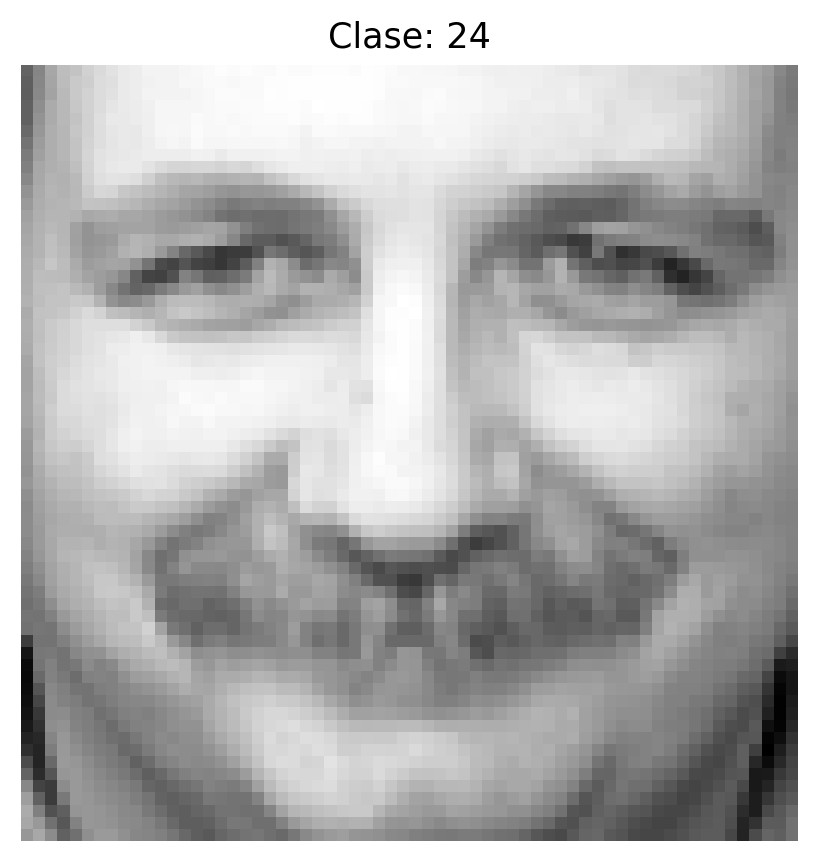

In [8]:
#TEST_CELL
show_face(X[50].reshape(64, 64),
          title = f'Clase: {y[50]}')

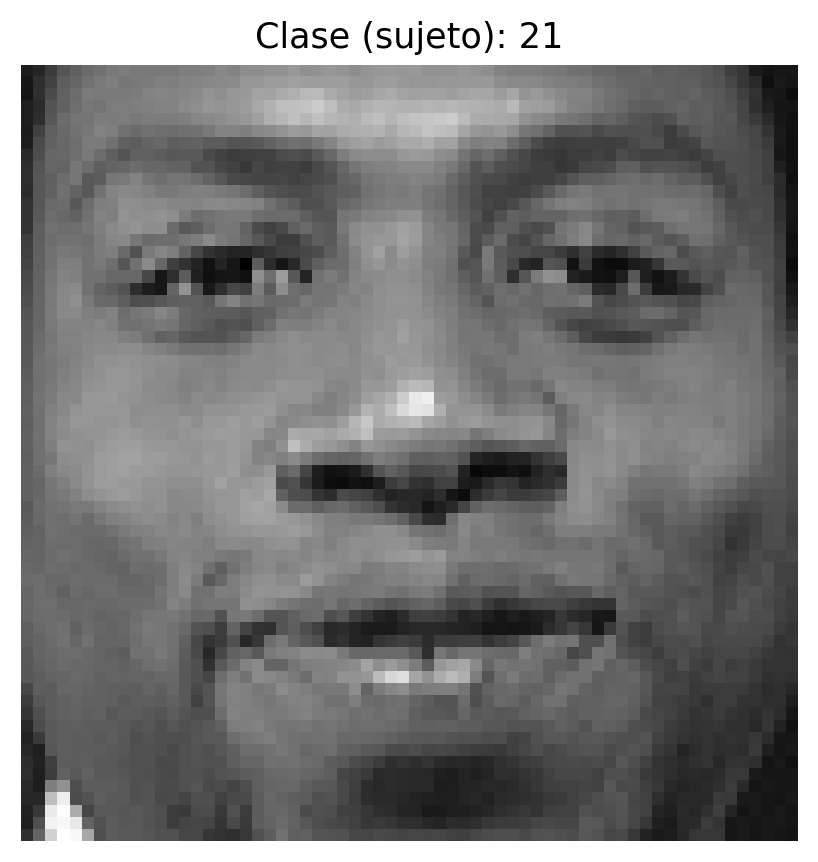

In [9]:
#TEST_CELL
#@title  { run: "auto" }
#@markdown Con el siguiente *slider* puede variar entre las observaciones una a visualizar. Puede cambiar este valor por un número entre 0 y 399. Elija el índice del arreglo que desea revisar:

# Mostrar la observación n-ésima del dataset con su etiqueta correspondiente.
index = 33 #@param {type:"slider", min:0, max:399, step:1}

show_face(X[index].reshape(64, 64),
          title = f'Clase (sujeto): {y[index]}')

Ahora, realizaremos la división en conjuntos de entrenamiento y evaluación. Utilizaremos $70\%$ para entrenamiento y $30\%$ para prueba. Se realizará de manera estratificada para no cambiar la distribución de cada clase.

In [10]:
#TEST_CELL
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state=14,
                                                    stratify=y)

In [11]:
#TEST_CELL
print(f'El shape de X_train es: : {X_train.shape}')

El shape de X_train es: : (280, 4096)


## **1. Componentes principales mínimos.**
---

Cuando se trabaja con datos de alta dimensionalidad, como en imágenes o texto, es muy util y apropiado reducir las características necesarias para representar un mínimo de información, en este caso debido a la varianza explicada de una representación.

Nos interesa encontrar la cantidad mínima de componentes principales de tal manera que se pueda realizar una representación que tenga por lo menos una varianza determinada.

Complete la función **`componentes_minimos`** de tal manera que retorne un entero **`min_comp`** con el número mínimo de componentes principales necesarios para obtener una varianza mayor a la entregada en el argumento **`min_var`** al aplicar el algoritmo *PCA*.


**Entrada:**

* **`X`**: arreglo de _NumPy_ de tamaño $(n, m)$ con el conjunto de datos de entrada para el análisis de componentes principales _PCA_.
* **`min_var`**: número real con el mínimo de varianza explicada acumulada necesario para obtener el número de componentes.

**Salida:**

* **`min_comp`**: número entero con el mínimo de componentes de _PCA_ necesarios para explicar por lo menos **`min_var`** varianza.

In [46]:
# FUNCIÓN CALIFICADA componentes_minimos:

# Funciones utilizadas en el ejercicio.
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA

def componentes_minimos(X, min_var=0.5):
    pca = PCA()
    pca.fit(X)
    varianza_acumulada = pca.explained_variance_ratio_.cumsum()
    min_comp = next(i for i, var in enumerate(varianza_acumulada) if var >= min_var) + 1
    return min_comp


Utilice las siguientes celdas para probar su código:

In [47]:
#TEST_CELL
min_comp = componentes_minimos(X_train, 0.5)

print(f'Se necesita por lo menos {min_comp} componentes para una varianza explicada de {0.5}.')

Se necesita por lo menos 4 componentes para una varianza explicada de 0.5.


**Salida esperada:**

```
Se necesita por lo menos 4 componentes para una varianza explicada de 0.5.
```

In [48]:
#TEST_CELL
min_comp = componentes_minimos(X_train, 0.8)

print(f'Se necesita por lo menos {min_comp} componentes para una varianza explicada de {0.8}.')

Se necesita por lo menos 25 componentes para una varianza explicada de 0.8.


**Salida esperada:**

```
Se necesita por lo menos 25 componentes para una varianza explicada de 0.8.
```

In [15]:
#TEST_CELL
min_comp = componentes_minimos(X_train, 0.35)

print(f'Se necesita por lo menos {min_comp} componentes para una varianza explicada de {0.35}.')

Se necesita por lo menos None componentes para una varianza explicada de 0.35.


**Salida esperada:**

```
Se necesita por lo menos 2 componentes para una varianza explicada de 0.35.
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Construya un objeto **`PCA`** que utilice como datos de entrada el conjunto de datos **`X`** y explore el atributo **`explained_variance_ratio_`**.



<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Recuerde que se busca que la varianza **acumulada** sea mayor a un valor determinado. Puede usar la función **`np.cumsum`** para obtener el arreglo de valores acumulados.


### **Evaluar código**

In [49]:
grader.run_test("Test 1_1", globals())

Test 1_1


In [50]:
grader.run_test("Test 1_2", globals())

Test 1_2


## **2. Representación de *eigenfaces*.**
---
Un resultado interesante del uso de técnicas de reducción de la dimensionalidad como *PCA* en imágenes es el obtenido al utilizar todos sus componentes. Cuando se realiza de esta manera, los componentes principales (también conocidos como *eigenvectores*) tienen el mismo tamaño que el vector original, abriendo la puerta a visualizar estos vectores de la misma manera que se haría al interpretarlos como imágenes. En el campo del reconocimiento facial ocurre un fenómeno conocido como *eigenface*, tras el cual la representación de los componentes principales de un conjunto de rostros da como resultado unos peculiares rostros que de alguna forma son una representación estadística de aquellos usados en el entrenamiento.

Su tarea consiste en completar la función **`eigenfaces`**, que toma como argumento un valor entero **`comp`**, siendo el índice o posición del componente principal que se desea representar. Esta función debe retornar dicho componente como una matriz **`eigenface`** de $64 \times 64$ que pueda ser representada como una imagen.



**Entrada:**

* **`X`**: arreglo de _NumPy_ de tamaño $(n, 4096)$ con el conjunto de datos de entrada para el análisis de componentes principales _PCA_.
* **`comp`**: número entero, posición del componente principal a retornar en un formato válido.

**Salida**:

* **`eigenface`**: arreglo de _NumPy_ con el **`comp`**-ésimo componente principal del conjunto de datos **`X`** con tamaño $(64, 64)$.


In [51]:
# FUNCIÓN CALIFICADA eigenfaces:

# Funciones utilizadas en el ejercicio.
from sklearn.decomposition import PCA

def eigenfaces(X, comp):
    pca = PCA()
    pca.fit(X)
    eigenvector = pca.components_[comp]
    eigenface = eigenvector.reshape(64, 64)
    return eigenface


In [53]:
#TEST_CELL
eigenface = eigenfaces(X_train, 10)

if isinstance(eigenface, np.ndarray):
  print(np.round(eigenface[0, :5], 5))
else: print("El arreglo retornado no es válido.")

[-0.00659 -0.00077  0.00815  0.01573  0.02034]


**Salida esperada:**
```
[-0.00659 -0.00077  0.00815  0.01573  0.02034]
```

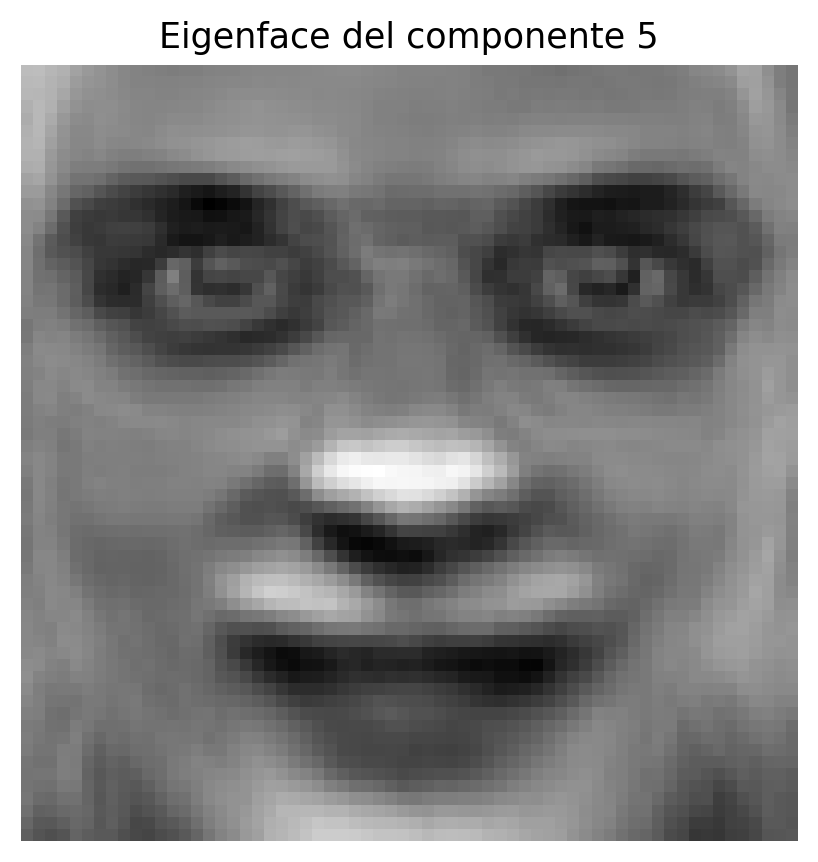

In [54]:
#TEST_CELL
eigenface = eigenfaces(X_train, 5)

if isinstance(eigenface, np.ndarray):
  show_face(eigenface, 'Eigenface del componente 5')
else: print("El arreglo retornado no es válido.")

**Salida esperada:**

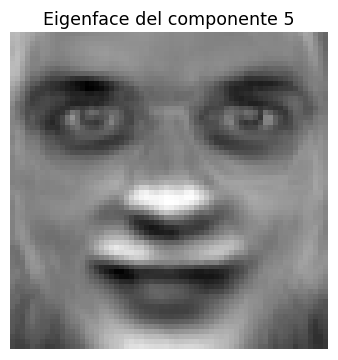

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Construya un objeto **`PCA`** que utilice como datos de entrada el conjunto de datos **`X`** y explore el atributo **`components_`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Utilice la función **`reshape`** para cambiar las dimensiones del arreglo de *NumPy*.


### **Evaluar código**

In [55]:
grader.run_test("Test 2_1", globals())

Test 2_1


In [56]:
grader.run_test("Test 2_2", globals())

Test 2_2


In [57]:
grader.run_test("Test 2_3", globals())

Test 2_3


## **3. Compresión y reconstrucción de imágenes.**
---
La técnica *PCA* permite reducir la cantidad de características de un dato y por ende, el espacio necesario para almacenarlo. Si bien la aproximación de *PCA* es estadística y sus resultados no necesariamente son generalizables a imágenes sueltas, este es el principio de otros algoritmos de compresión de imágenes con perdida de información como *JPEG*.

Su tarea es implementar la función **`pca_representacion`** que tomará como argumento el número de componentes utilizados **`n_comp`** en la imagen comprimida. Además, recibirá como entrada un vector **`img`** de tamaño $4096$, que deberá pasar por un proceso de transformación/transformación inversa usando *PCA* con la cantidad de componentes especificado realizado sobre al arreglo **`X`**. El resultado deberá ser retornado como resultado de la función como una matriz de tamaño $64 \times 64$.

**Entrada:**

* **`X`**: arreglo de _NumPy_ de tamaño $(n, 4096)$ con el conjunto de datos de entrada para el análisis de componentes principales _PCA_.
* **`n_comp`**: número entero con el total de componentes a usar en la transformación realizada con _PCA_.
* **`img`**: arreglo de _NumPy_ de tamaño $(4096, )$ con la imagen que se desea transformar.
* **`seed`**: número entero con la semilla aleatoria para el algoritmo _PCA_.

  > **Nota:** la ejecución del algoritmo _PCA_ de _Scikit-Learn_ depende de un proceso aleatorio cuando la cantidad de componentes es menor que el total de características usadas en su ajuste. Utilice el valor dado en **`seed`** para definir el **`random_state`** en el constructor de **`PCA`**.

**Salida:**
* **`reconstructed_img`**: arreglo de _NumPy_ de tamaño $(64, 64)$ con el resultado de aplicar la transformación de _PCA_ con un total de **`n_comp`** componentes y posteriormente la transformación inversa de la imagen de entrada **`img`**.

In [58]:
from sklearn.decomposition import PCA

def pca_representacion(X, n_comp, img, seed=215):
    pca = PCA(n_components=n_comp, random_state=seed)
    pca.fit(X)
    img_transformed = pca.transform([img])
    img_reconstructed = pca.inverse_transform(img_transformed)
    reconstructed_img = img_reconstructed.reshape(64, 64)
    return reconstructed_img


Use las siguientes celdas para probar su código:

In [59]:
#TEST_CELL
test_id = 50
test_result = pca_representacion(X_train, 100, X_test[test_id])

if isinstance(test_result, np.ndarray):
  print(np.round(test_result[0][:5], 4))
else: print("El arreglo retornado no es válido.")

[0.5678 0.6046 0.5943 0.5918 0.6036]


**Salida esperada**:
```
[0.5678 0.6046 0.5943 0.5918 0.6036]
```

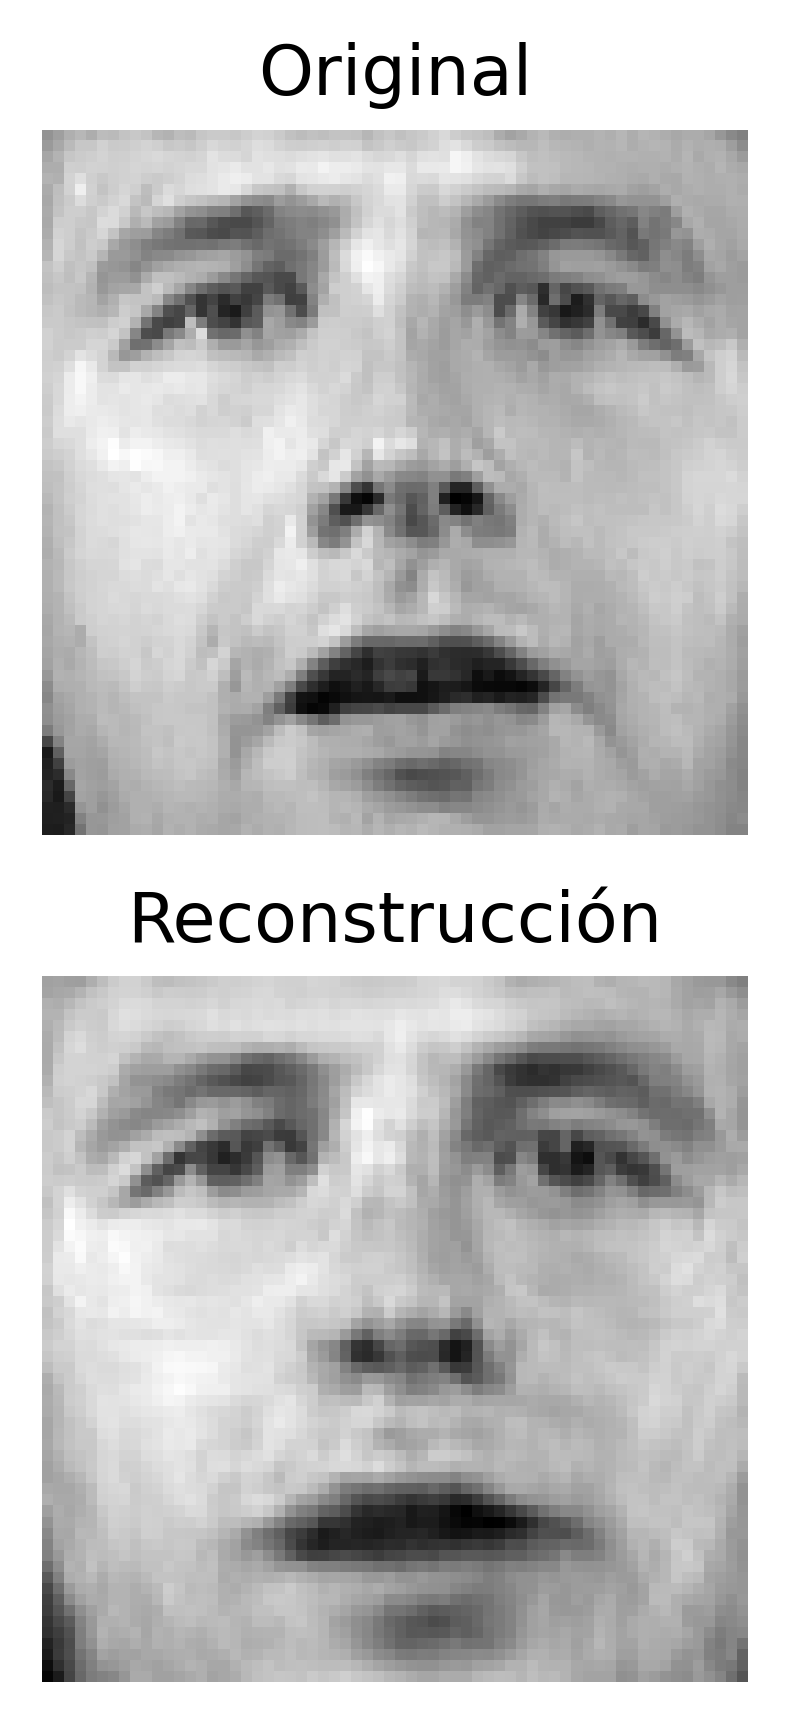

In [60]:
#TEST_CELL
test_id = 25
test_result = pca_representacion(X_train, 100, X_test[test_id])
test_original = X_test[test_id].reshape(64, 64)

if isinstance(test_result, np.ndarray):
  fig, axes = plt.subplots(dpi = 210, nrows = 2)
  show_face(test_original, 'Original', ax = axes[0])
  show_face(test_result, 'Reconstrucción', ax = axes[1])
else: print("El arreglo retornado no es válido.")

**Salida esperada:**

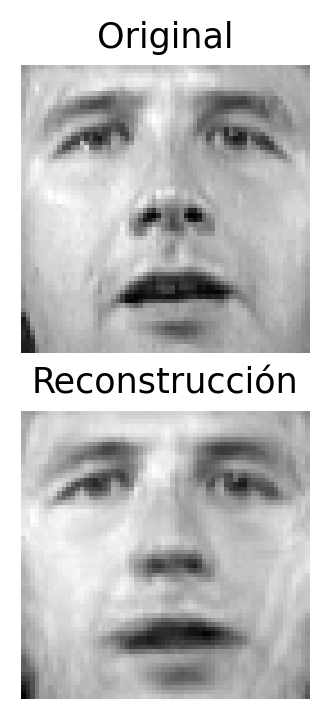

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Construya un objeto **`PCA`** que utilice como datos de entrada el conjunto de datos **`X`**, con **`n_comp`** componentes y semilla aleatoria **`seed`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Aplique tanto **`transform`** como **`inverse_transform`** al objeto **`img`** y retorne el resultado transformado a las dimensiones correspondientes.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Use **`reshape(64, 64)`** con la imagen reconstruida para cambiar sus dimensiones.

### **Evaluar código**

In [61]:
grader.run_test("Test 3_1", globals())

Test 3_1


In [62]:
grader.run_test("Test 3_2", globals())

Test 3_2


In [63]:
grader.run_test("Test 3_3", globals())

Test 3_3


In [64]:
grader.run_test("Test 3_4", globals())

Test 3_4


In [65]:
grader.run_test("Test 3_5", globals())

Test 3_5


## **4. Fusión de rostros.**
---
La representación de rostros por medio de *eigenfaces* o componentes principales de menor dimensión permiten realizar operaciones entre ellos como la fusión. Para ello, se representan las dos imágenes a combinar con la misma dimensión y se realiza un promedio de sus valores. Las características estadísticas de ambos rostros se promedian dando paso a una nueva representación que puede pasar por un proceso de transformación inversa. Este proceso está descrito por:

$$ \text{fusion}(a,b) = f^\prime \left( \frac{f(a) + f(b)}{2}\right) $$

donde $f(x)$ es la función de transformación de los datos originales a la representación con menor dimensionalidad y $f^\prime(x)$ la función inversa de transformación obtenida del método _PCA_. Tanto $a$ como $b$ son observaciones del conjunto de datos.

Su tarea es realizar el proceso descrito anteriormente para la fusión de dos rostros, representados por los vectores **`a`** y **`b`**. Deberá implementar la función **`fusion_rostros`**, a la que se pasarán como argumentos los dos vectores y el entero **`n_comp`** con el número de componentes utilizados por _PCA_ para la nueva representación. Se deberá realizar la transformación, combinación y recuperación de una imagen nueva, que será retornada como una matriz de $64 \times 64$ valores numéricos.


**Entrada:**

* **`X`**: arreglo de _NumPy_ de tamaño $(n, 4096)$ con el conjunto de datos de entrada para el análisis de componentes principales _PCA_.
* **`n_comp`**: número entero con el total de componentes a usar en la transformación realizada con _PCA_.
* **`a`**: arreglo de _NumPy_ de tamaño $(4096, )$ con la imagen del primer rostro.
* **`b`**: arreglo de _NumPy_ de tamaño $(4096, )$ con la imagen del segundo rostro.
* **`seed`**: número entero con la semilla aleatoria para el algoritmo _PCA_.

**Salida:**
* **`reconstructed_img`**: arreglo de _NumPy_ de tamaño $(64, 64)$ con el resultado de aplicar la transformación de _PCA_ con un total de **`n_comp`** componentes y posteriormente la transformación inversa de la imagen de entrada **`img`**.

In [66]:
from sklearn.decomposition import PCA

def fusion_rostros(X, n_comp, a, b, seed=125):
    pca = PCA(n_components=n_comp, random_state=seed)
    pca.fit(X)
    a_transformed = pca.transform([a])
    b_transformed = pca.transform([b])
    fusion_transformed = (a_transformed + b_transformed) / 2
    fusion_inverse = pca.inverse_transform(fusion_transformed)
    fusioned_face = fusion_inverse.reshape(64, 64)
    return fusioned_face


In [67]:
#TEST_CELL
x_a =  X_train[25]
x_b =  X_train[50]

fusión = fusion_rostros(X_train, 100, x_a, x_b)
if isinstance(fusión, np.ndarray):
  print(np.round(fusión[0][:5], 4))
else: print("El arreglo retornado no es válido.")

[0.3803 0.4216 0.473  0.5298 0.5681]


**Salida esperada:**

```
[0.3803 0.4216 0.473  0.5298 0.5681]
```

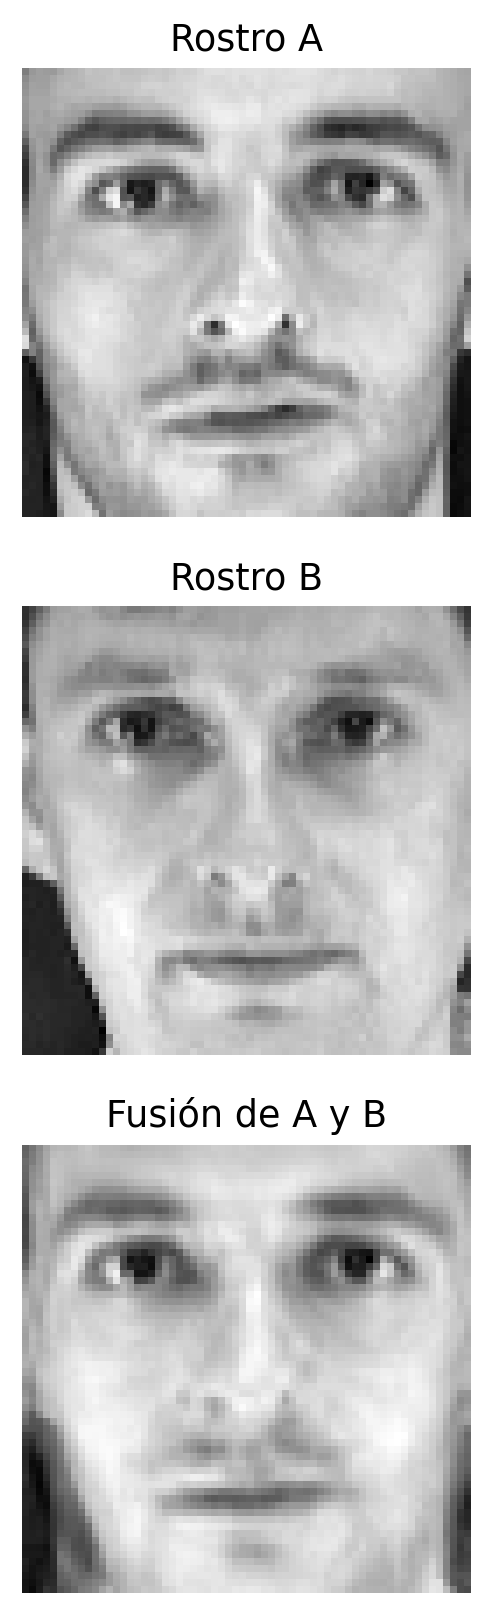

In [68]:
#TEST_CELL
x_a =  X_train[25]
x_b =  X_train[50]
fusión = fusion_rostros(X_train, 100, x_a, x_b)

if isinstance(fusión, np.ndarray):
  fig, axes = plt.subplots(dpi = 110, nrows = 3, figsize = (4, 9))
  show_face(x_a.reshape(64,64), 'Rostro A', ax = axes[0])
  show_face(x_b.reshape(64,64), 'Rostro B', ax = axes[1])
  show_face(fusión, 'Fusión de A y B', ax = axes[2])
else: print("El arreglo retornado no es válido.")

**Salida esperada:**

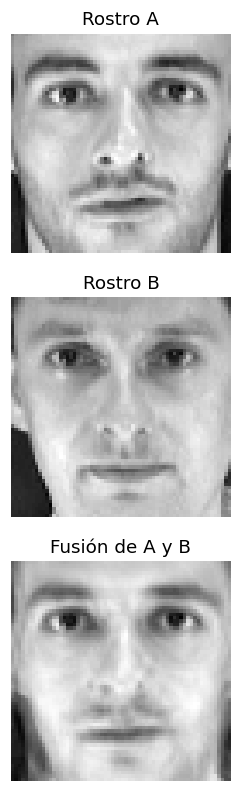

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Construya un objeto **`PCA`** que utilice como datos de entrada el conjunto de datos **`X`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Calcule la representación de _PCA_ de los rostros **`a`** y **`b`**. **`rep_a`** y **`rep_b`** correspondientemente. Luego, calcule el promedio de las representaciones como la suma de la mitad de **`rep_a`** y la mitad de **`rep_b`** con operaciones matemáticas entre arreglos de _NumPy_.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Aplique la transformación inversa a el promedio de las representaciones y use **`reshape(64, 64)`** con la imagen reconstruida.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 4</b></font>
</summary>

* Recuerde que las funciones de *Scikit-Learn* reciben como entrada un conjunto de observaciones. Como se requiere usar únicamente una observación, es necesario envolverla en un arreglo o lista conteniendo únicamente dicha observación.

### **Evaluar código**

In [69]:
grader.run_test("Test 4_1", globals())

Test 4_1


In [70]:
grader.run_test("Test 4_2", globals())

Test 4_2


In [71]:
grader.run_test("Test 4_3", globals())

Test 4_3


In [72]:
grader.run_test("Test 4_4", globals())

Test 4_4


In [73]:
grader.run_test("Test 4_5", globals())

Test 4_5


## **5. Modelado con *pipeline*.**
---

Este *dataset* está diseñado para realizar tareas de clasificación, en donde los datos de entrada son el tono de cada píxel de la imagen y la variable objetivo un valor representando una persona específica. En total se consideran $40$ personas, cada una con $10$ imágenes con gestos y posiciones distintas.

En este punto debe implementar la función **`entrenar_pipeline`** de tal manera que reciba la partición de datos de entrenamiento **`X_train`**, **`y_train`**, un entero **`k`** con el número de pliegues de validación cruzada y un diccionario de parámetros y retorne un **`Pipeline`** entrenado con **`GridSearchCV`**.

El objeto **`Pipeline`** estará compuesto por dos etapas. En el primero, se realizará una reducción de la dimensionalidad con **`PCA`** y en la segunda se entrenará un modelo de clasificación con vectores de soporte con la función **`SVC`**. Los nombres de las etapas deberán ser **`'pca'`** y **`'svc'`**, respectivamente.

**Entrada:**

* **`X_train`**: arreglo de _NumPy_ de tamaño $(n, 4096)$ con el conjunto de datos de entrada.
* **`y_train`**: arreglo de _NumPy_ de tamaño $(n, )$ con el vector de etiquetas reales.
* **`params`**: diccionario con las listas de valores posibles de cada hiperparámetro de los estimadores **`PCA`** y **`SVC`** de *Scikit-Learn* en formato de prefijo apto para validación cruzada de _pipelines_.
* **`k`**: número entero del total de pliegues de validación cruzada que se deben explorar en la búsqueda de hiperparámetros.
* **`seed`**: número entero con la semilla aleatoria para los estimadores **`PCA`** y **`SVC`**.

  > **Nota:** la ejecución de los estimadores **`PCA`** y **`SVC`** de _Scikit-Learn_ depende de procesos aleatorios independientes. En este caso, deberá utilizar el mismo valor dado en **`seed`** para definir el **`random_state`** en el constructor de ambos estimadores.

**Salida:**
* **`gsearch`**: objeto **`GridSearchCV`** entrenado sobre un objeto **`Pipeline`** compuesto por los estimadores **`PCA`** y **`SVC`** y con los datos de entrenamiento **`X_train`** y **`y_train`**.






In [74]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def entrenar_pipeline(X_train, y_train, params, k, seed=125):
    pipeline = Pipeline([
        ('pca', PCA(random_state=seed)),
        ('svc', SVC(random_state=seed))
    ])

    gsearch = GridSearchCV(pipeline, param_grid=params, cv=k)
    gsearch.fit(X_train, y_train)

    return gsearch


In [75]:
#TEST_CELL
parameters = {
    'pca__n_components': [2, 5, 10, 25],
    'svc__kernel': ['rbf', 'sigmoid']
}
gsearch = entrenar_pipeline(X_train, y_train, parameters, k=4)

try:
  print("Mejor configuración de parámetros:")

  best_parameters = gsearch.best_params_
  for param in sorted(parameters.keys()):
      print(f"\t{param}: {best_parameters[param]}")

  print(f"Exactitud (val): {gsearch.best_score_:.4f}")
  print(f'Exactitud (test): {gsearch.score(X_test, y_test):.4f}')
except Exception as e:
  print("El objeto GridSearchCV no es válido:")
  print(e)

Mejor configuración de parámetros:
	pca__n_components: 25
	svc__kernel: rbf
Exactitud (val): 0.8536
Exactitud (test): 0.9000


**Salida esperada:**
```
Mejor configuración de parámetros:
	pca__n_components: 25
	svc__kernel: rbf
Exactitud (val): 0.8536
Exactitud (test): 0.9000
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* En esta tarea usted deberá importar los módulos necesarios, que incluyen estimadores y demás objetos necesarios.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Los estimadores usados en el *pipeline* solo deberían recibir como parámetro la semilla aleatoria **`seed`** dada. Todos los hiperparámetros a considerar se pasarán por medio del objeto **`params`**.
* Verifique que usó los nombres correctos en la tupla id-estimador. Si no están escritos de igual manera el programa fallará. Esto incluye caracteres en mayúscula/minúscula, entre otros.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* El parámetro **`verbose`** de **`GridSearchCV`** puede generar problemas en la calificación. Se le recomienda usarlo para evaluar e inspeccionar los resultados y dejarlo con valor $0$ o no definirlo cuando vaya a realizar la entrega.


### **Evaluar código**

In [76]:
grader.run_test("Test 5_1", globals())

Test 5_1


In [77]:
grader.run_test("Test 5_2", globals())

Test 5_2


## **6. Reporte del desempeño del *pipeline***
---
Finalmente, evaluaremos el *pipeline* construido en el punto anterior con la ayuda de métricas de rendimiento como la exactitud, _recall_, precisión y $f_1$. En esta ocasión, deberá utilizar una función de _Scikit-Learn_ vista en el curso para obtener un **reporte de clasificación**.

Para esto, recibirá como argumentos de entrada el objeto **`model`** con un modelo de clasificación entrenado y los conjuntos $X$ y $y$ para evaluación. Deberá retornar la cadena de texto generada en el reporte de clasificación con $4$ dígitos de precisión en los valores numéricos.

> **Nota:** Identifique la función apropiada y consulte su documentación para encontrar la manera de alterar la precisión y compare su resultado con las celdas de prueba.


**Entrada:**

* **`model`**: modelo de clasificación de _Scikit-Learn_.
> **Nota:** este objeto corresponde a cualquier modelo que corresponda al _API_ básica de los clasificadores de _Scikit-Learn_, incluyendo objetos de tipo **`GridSearchCV`** y **`PipeLine`** para clasificación.
* **`X_test`**: arreglo de *NumPy* de tamaño $(n, m)$ para evaluación.
* **`y_test`**: arreglo de *NumPy* de tamaño $(n, )$ para evaluación.

**Salida**:

* **`report`**: cadena de texto con el reporte por clase de la clasificación realizada.



In [78]:
from sklearn.metrics import classification_report

def reporte_desempeño(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, digits=4)
    return report


In [79]:
#TEST_CELL
parameters = {
    'pca__n_components': [2, 5, 10, 25],
    'svc__kernel': ['rbf', 'sigmoid']
}
# Ejercicio 5. Entrenamiento de modelo de clasificación GridSearchCV con Pipeline.
gsearch = entrenar_pipeline(X_train, y_train, parameters, k=4)
assert isinstance(gsearch,
                  sklearn.model_selection._search.GridSearchCV), "Ej 5. Revise el ejercicio 5."

print(reporte_desempeño(gsearch, X_test, y_test))

              precision    recall  f1-score   support

           0     0.3333    0.3333    0.3333         3
           1     1.0000    1.0000    1.0000         3
           2     1.0000    1.0000    1.0000         3
           3     0.6667    0.6667    0.6667         3
           4     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    0.6667    0.8000         3
           8     1.0000    0.6667    0.8000         3
           9     0.7500    1.0000    0.8571         3
          10     1.0000    1.0000    1.0000         3
          11     1.0000    1.0000    1.0000         3
          12     1.0000    0.3333    0.5000         3
          13     1.0000    1.0000    1.0000         3
          14     1.0000    1.0000    1.0000         3
          15     1.0000    0.6667    0.8000         3
          16     0.7500    1.0000    0.8571         3
          17     1.0000    

**Salida esperada**:

```
   precision    recall  f1-score   support

           0     0.3333    0.3333    0.3333         3
           1     1.0000    1.0000    1.0000         3
           2     1.0000    1.0000    1.0000         3
           3     0.6667    0.6667    0.6667         3
           4     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    0.6667    0.8000         3
           8     1.0000    0.6667    0.8000         3
           9     0.7500    1.0000    0.8571         3
          10     1.0000    1.0000    1.0000         3
          11     1.0000    1.0000    1.0000         3
          12     1.0000    0.3333    0.5000         3
          13     1.0000    1.0000    1.0000         3
          14     1.0000    1.0000    1.0000         3
          15     1.0000    0.6667    0.8000         3
          16     0.7500    1.0000    0.8571         3
          17     1.0000    1.0000    1.0000         3
          18     1.0000    1.0000    1.0000         3
          19     1.0000    1.0000    1.0000         3
          20     0.7500    1.0000    0.8571         3
          21     1.0000    1.0000    1.0000         3
          22     0.7500    1.0000    0.8571         3
          23     1.0000    0.6667    0.8000         3
          24     0.6667    0.6667    0.6667         3
          25     1.0000    0.6667    0.8000         3
          26     1.0000    1.0000    1.0000         3
          27     1.0000    1.0000    1.0000         3
          28     1.0000    1.0000    1.0000         3
          29     1.0000    1.0000    1.0000         3
          30     1.0000    1.0000    1.0000         3
          31     1.0000    1.0000    1.0000         3
          32     1.0000    1.0000    1.0000         3
          33     1.0000    1.0000    1.0000         3
          34     1.0000    0.6667    0.8000         3
          35     1.0000    1.0000    1.0000         3
          36     1.0000    1.0000    1.0000         3
          37     1.0000    1.0000    1.0000         3
          38     1.0000    1.0000    1.0000         3
          39     0.4286    1.0000    0.6000         3

    accuracy                         0.9000       120
   macro avg     0.9274    0.9000    0.8999       120
weighted avg     0.9274    0.9000    0.8999       120
```

In [ ]:
#TEST_CELL
#@title  { run: "auto", vertical-output: true }
#@markdown En la evaluación anterior podemos apreciar que la clase con el f1-score binario más bajo es el que tiene el índice 0. Ejecute esta celda para graficar las imágenes del sujeto del índice seleccionado con el _slider_.
#@markdown > Al explorar las imágenes del sujeto podemos ver que algunas tienen características distintas, como la inclinación y la posición del rostro, que pueden haber derivado en una clasificación erronea por parte del modelo. Lo invitamos a que explore otros registros y características del conjunto de datos.
from google.colab import widgets


subject_id = 16 #@param {type:"slider", min:0, max:39, step:1}


subject_imgs = X[y == subject_id]

tb = widgets.TabBar([f'{k + 1}' for k in range(10)])
for i in range(10):
  with tb.output_to(i, select= (i < 1)):
    show_face(subject_imgs[i].reshape(64, 64),
          title = f'Foto {i + 1} del sujeto {subject_id}')
    plt.show()


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* En esta tarea usted deberá importar los módulos necesarios de métricas de rendimiento discutidas en el curso. Consulte el material previo o la [documentación](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) de métricas de *Scikit-Learn*.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* El objeto **`gsearch`** no debería ser modificado, ni se tiene que entrenar nuevamente. Utilice únicamente funciones que no alteren su entrenamiento como **`predict`**, **`score`** o alguno de sus múltiples atributos.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Utilice la función **`classification_report`** y defina el número de dígitos según se indica en su [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report).


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 4</b></font>
</summary>

* Utilice el argumento **`digits`** de **`classification_report`** para definir el número de dígitos.


### **Evaluar código**

In [81]:
grader.run_test("Test 6_1", globals())

Test 6_1


In [82]:
grader.run_test("Test 6_2", globals())

Test 6_2


**¡Felicitaciones!** Ha terminado la tarea de la Unidad 5. ¡Buen trabajo!

## **Evaluación**

In [83]:
grader.submit_task(globals())

Test 1_1
Test 1_2
Test 2_1
Test 2_2
Test 2_3
Test 3_1
Test 3_2
Test 3_3
Test 3_4
Test 3_5
Test 4_1
Test 4_2
Test 4_3
Test 4_4
Test 4_5
Test 5_1
Test 5_2
Test 6_1
Test 6_2


## **Créditos**
---
* **Profesor:** [Fabio Augusto González](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:**
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*